In [98]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import cm
from matplotlib.ticker import LinearLocator

We have Burgers' equation

$$
\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}f(u) = 0.
$$

Here $f(u) = \frac{1}{2}u^2$. We have discretized along time, so we have $u$ at time $n$, ie $u^n$. We have also defined our mesh along integer nodes, so $u_i$. Note the above can be rewritten as

$$
\frac{du_i}{dt} = -\left[\frac{\partial f}{\partial x}\right]_{x = x_i}.
$$

Define a function $h$ such that

$$
f(x) = \frac{1}{\Delta x}\int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}{h(\xi)d\xi}.
$$

Inserting this into the above and applying the Fundamental Theorem of Calculus, we see

$$
\frac{du_i}{dt} = -\frac{1}{\Delta x}\left(h_{i+\frac{1}{2}} - h_{i-\frac{1}{2}}\right).
$$

First, a particular example we will move on to generalize. We wish to approximate $h_{\frac{1}{2}}$ with a second degree polynomial $P(x) = ax^2 + bx + c$. Given the definition, we know

$$
\begin{split}
f_{-1} &= \int_{-\frac{3}{2}}^{-\frac{1}{2}}{h(x)dx} \\
&\approx \int_{-\frac{3}{2}}^{-\frac{1}{2}}{P(x)dx} \\
&= \int_{-\frac{3}{2}}^{-\frac{1}{2}}{\left(ax^2 + bx + c\right)dx} \\
&= \left[\frac{1}{3}ax^3 + \frac{1}{2}bx^2 + cx\right]_{-\frac{3}{2}}^{-\frac{1}{2}} \\
&= \left(\left(\frac{1}{3}a\left(-\frac{1}{2}\right)^3 + \frac{1}{2}b\left(-\frac{1}{2}\right)^2 + c\left(-\frac{1}{2}\right)\right) - \left(\frac{1}{3}a\left(-\frac{1}{2}\right)^3 + \frac{1}{2}b\left(-\frac{1}{2}\right)^2 + c\left(-\frac{1}{2}\right)\right)\right) \\
&= c - b + \frac{13}{12}a.
\end{split} \\

\begin{split}
f_{0} &= \int_{-\frac{1}{2}}^{\frac{1}{2}}{h(x)dx} \\
&= ... \\
&= c + \frac{1}{12}a
\end{split} \\

\begin{split}
f_{1} &= \int_{\frac{1}{2}}^{\frac{3}{2}}{h(x)dx} \\
&= ... \\
&= c - b + \frac{13}{12}a
\end{split}
$$

We can generalize this. Simply let $\eta = \frac{1}{\Delta x}\left(\xi - x_i\right)$ and we see from change of variable

$$
    \frac{1}{\Delta x}\int_{x_{i} - \frac{\Delta x}{2}}^{x_{i} + \frac{\Delta x}{2}}{h(\xi)d\xi} = \int_{-\frac{1}{2}}^{\frac{1}{2}}{h(\eta)d\eta}.
$$

Doing similar will yield the appropriate weights, and so long as we remember to do the appropriate change of variable, all will be well.

This becomes the linear system

$$
\begin{pmatrix}
\frac{1}{3}\left(x_{i-\frac{1}{2}}^{3} - x_{i-\frac{3}{2}}^{3}\right) & \frac{1}{2}\left(x_{i-\frac{1}{2}}^{2} - x_{i-\frac{3}{2}}^{2}\right) & \left(x_{i-\frac{1}{2}} - x_{i-\frac{3}{2}}\right) \\
\frac{1}{3}\left(x_{i+\frac{1}{2}}^{3} - x_{i-\frac{1}{2}}^{3}\right) & \frac{1}{2}\left(x_{i+\frac{1}{2}}^{2} - x_{i-\frac{1}{2}}^{2}\right) & \left(x_{i+\frac{1}{2}} - x_{i-\frac{1}{2}}\right) \\
\frac{1}{3}\left(x_{i+\frac{3}{2}}^{3} - x_{i+\frac{1}{2}}^{3}\right) & \frac{1}{2}\left(x_{i+\frac{3}{2}}^{2} - x_{i+\frac{1}{2}}^{2}\right) & \left(x_{i+\frac{3}{2}} - x_{i+\frac{1}{2}}\right)
\end{pmatrix}
\begin{pmatrix}
a \\ b \\ c
\end{pmatrix}
=
\begin{pmatrix}
f_{i-1} \\ f_{i} \\ f_{i+1}.
\end{pmatrix}
$$

This is a rather gnarled expression, especially when inverted. The $k$ coefficients for the $j$ th stencil may be tidily computed by the following closed form expression

$$
c_{kj} = \sum_{m=j+1}^{r}{\left(\sum_{l=0,l\leq m}^{r}{\prod_{n=0,n\leq m}^{r}{\left(k-n+1\right)}}\right)\left(\prod_{l=0,l\leq m}^{r}{\left(m - l\right)}\right)^{-1}}
$$

In [3]:
def l1_norm(arr,N):
    norm = sum([abs(x) for x in arr])
    return norm/(N-1)

def l2_norm(arr,N):
    norm_squared = sum([x**2 for x in arr])
    return np.sqrt(norm_squared/(N-1))

def inf_norm(arr):
    return np.max(np.abs(arr))

In [4]:
def add_ghost_cells(a,n_points,n_ghost):
    '''
    Our N sized array for a, x:
                                ###        ###        ###        ###         ###       ###        ###
                            |----------|----------|----------|----------|----------|----------|----------|

    Our N+2*(N_ghost) array for a_with_ghost, x_with_ghost

            0          0         ###         ###       ###         ###       ###         ###       ###          0         0 
    |----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
    
    '''

    a_with_ghost = np.zeros(n_points+(2*n_ghost))

    a_with_ghost[(n_ghost):-1*(n_ghost)] = a[:]
    
    return a_with_ghost

In [5]:
def boundary_conditions(a_with_ghost,N_ghost,type="periodic"):
    '''
    Type 1: "periodic" our a array loops around such that a[N - 1] is next to a[0]
    Type 2: "dirichlet" waves disappear when they reach the edges of the domain
                        
    If we have the domain as follows, where |~~~~~~~| signifies ghost cells

	    [0]        [1]         [2]        [3]                 [...]                  [N]       [N+1]      [N+2]      [N+3]
	|~~~~~~~~~~|~~~~~~~~~~|----------|----------|----------|----------|----------|----------|----------|~~~~~~~~~~|~~~~~~~~~~|

    For periodic our swap for two ghost cells would be
    a[0] = a[N]
    a[1] = a[N+1]
    a[N+2] = a[2]
    a[N+3] = a[3]

    '''

    if type == "periodic":
        for i in range(N_ghost):
            a_with_ghost[i] = a_with_ghost[-2*N_ghost+i]
            a_with_ghost[-1*N_ghost+i] = a_with_ghost[N_ghost+i]

    elif type == "dirichlet":
        for i in range(N_ghost):
            a_with_ghost[i] = 0
            a_with_ghost[-1*N_ghost+i] = 0

    elif type == "reflective":
        for i in range(N_ghost):
            a_with_ghost[i] = a_with_ghost[N_ghost+i]
            a_with_ghost[-1*N_ghost+i] = a_with_ghost[-2*N_ghost+i]

    else:
        print("Invalid Boundary Condition Type!")

    return a_with_ghost
 

In [6]:
def get_max_value(*values):
    return max(values)

We have the function $u$ known at nodes $i$. Define cell average values:

$$
\bar{u}_i = \frac{1}{\Delta x}\int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}{u(x)dx}.
$$

Interpolate $u$ with a second degree polynomial $p_1$, so

$$
\bar{u}_i = \frac{1}{\Delta x}\int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}{p_1(x)dx} = \left(\bar{p}_1\right)_j.
$$

We have

$$
\begin{split}
u_{i + \frac{1}{2}}^{(1)} &= \frac{1}{3}\bar{u}_{i-2} - \frac{7}{6}\bar{u}_{i-1} + \frac{11}{6}\bar{u}_{i} \\
u_{i + \frac{1}{2}}^{(2)} &= -\frac{1}{6}\bar{u}_{i-1} - \frac{5}{6}\bar{u}_{i} + \frac{1}{3}\bar{u}_{i+1} \\
u_{i + \frac{1}{2}}^{(3)} &= \frac{1}{3}\bar{u}_{i} + \frac{5}{6}\bar{u}_{i+1} - \frac{1}{6}\bar{u}_{i+2}
\end{split}
$$

We then acquire

$$
u_{i+\frac{1}{2}} = \gamma_1u_{i + \frac{1}{2}}^{(1)} + \gamma_2u_{i + \frac{1}{2}}^{(2)} + \gamma_3u_{i + \frac{1}{2}}^{(3)}
$$

In [7]:
def weno_flux_splitting(w,flux,dflux):
    
    epsilon = 1E-6

    ################################################################################################
    # Lax-Friedrichs splitting
    # f^{±}(u) = 0.5 * (f(u) ± αu)
    # α = maxu |f′(u)|
    ################################################################################################
    
    a = 1.1 * get_max_value(np.abs(dflux(w)))

    v_arr = 0.5 * (flux(w) + a * w)
    u_arr = 0.5 * (flux(w) - a * w)

    ################################################################################################
    # Choose the positive fluxes: v_i = f^{+}(u_i)
    # to obtain the cell boundary values : v_{i+1/2}^{-}
    ################################################################################################
    
    vmm = v_arr[0]
    vm =  v_arr[1]
    v =   v_arr[2]
    vp =  v_arr[3]
    vpp = v_arr[4]

    beta_0n = (13.0/12.0)*(vmm - 2*vm +   v)**2. + (1.0/4.0)*(vmm - 4*vm + 3*v)**2.
    beta_1n = (13.0/12.0)*(vm  - 2*v  +  vp)**2. + (1.0/4.0)*(vm  - vp)**2.
    beta_2n = (13.0/12.0)*(v   - 2*vp + vpp)**2. + (1.0/4.0)*(vpp - 4*vp + 3*v)**2.

    d_0n = 1.0/10.0
    d_1n = 6.0/10.0
    d_2n = 3.0/10.0

    alpha_0n = d_0n / (epsilon + beta_0n)**2.
    alpha_1n = d_1n / (epsilon + beta_1n)**2.
    alpha_2n = d_2n / (epsilon + beta_2n)**2.

    alpha_sumn = alpha_0n + alpha_1n + alpha_2n

    weight_0n = alpha_0n / alpha_sumn
    weight_1n = alpha_1n / alpha_sumn
    weight_2n = alpha_2n / alpha_sumn

    p0 = 2*vmm - 7*vm + 11*v
    p1 = -vm  + 5*v  + 2*vp
    p2 = 2*v   + 5*vp - vpp

    wn  = (1.0/6.0)*( weight_0n*p0 + weight_1n*p1 + weight_2n*p2 )
    
    ################################################################################################
    # Choose the negative fluxes: v_i = f^{-}(u_i)
    # to obtain the cell boundary values : v_{i+1/2}^{+}
    ################################################################################################
    
    umm = u_arr[1]
    um =  u_arr[2]
    u =   u_arr[3]
    up =  u_arr[4]
    upp = u_arr[5]

    beta_0p = (13.0/12.0)*(umm - 2*um +   u)**2. + (1.0/4.0)*(umm - 4*um + 3*u)**2.
    beta_1p = (13.0/12.0)*(um  - 2*u  +  up)**2. + (1.0/4.0)*(um  - up)**2.
    beta_2p = (13.0/12.0)*(u   - 2*up + upp)**2. + (1.0/4.0)*(upp - 4*up + 3*u)**2.

    d_0p = 3.0/10.0
    d_1p = 6.0/10.0
    d_2p = 1.0/10.0

    alpha_0p = d_0p / (epsilon + beta_0p)**2.    
    alpha_1p = d_1p / (epsilon + beta_1p)**2.    
    alpha_2p = d_2p / (epsilon + beta_2p)**2.

    alpha_sump = alpha_0p + alpha_1p + alpha_2p

    weight_0p = alpha_0p / alpha_sump
    weight_1p = alpha_1p / alpha_sump
    weight_2p = alpha_2p / alpha_sump

    p0 = -umm + 5*um +   2*u
    p1 = 2*um + 5*u  -    up
    p2 = 11*u - 7*up + 2*upp

    wp  = (1.0/6.0)*( weight_0p*(p0) + weight_1p*(p1) + weight_2p*(p2) )
    
    ################################################################################################
    # Numerical flux
    # f_{i+1/2} = f_{i+1/2}^{+} + f_{i+1/2}^{-}
    ################################################################################################
    
    return wn + wp

In [38]:
def weno_flux_splitting_2D(wx,wy,flux_x,dflux_x,flux_y,dflux_y):
    
    epsilon = 1E-6

    ################################################################################################
    # Lax-Friedrichs splitting
    # f^{±}(u) = 0.5 * (f(u) ± αu)
    # α = maxu |f′(u)|
    ################################################################################################
    
    ax = 1.1 * get_max_value(np.abs(dflux_x(wx)))
    ay = 1.1 * get_max_value(np.abs(dflux_y(wy)))

    vx_arr = 0.5 * (flux(wx) + a * wx)
    ux_arr = 0.5 * (flux(wx) - a * wx)

    vy_arr = 0.5 * (flux(wy) + a * wy)
    uy_arr = 0.5 * (flux(wy) - a * wy)

    ################################################################################################
    # Choose the positive fluxes: v_i = f^{+}(u_i)
    # to obtain the cell boundary values : v_{i+1/2}^{-}
    ################################################################################################
    
    vmm = vx_arr[0]
    vm =  vx_arr[1]
    v =   vx_arr[2]
    vp =  vx_arr[3]
    vpp = vx_arr[4]

    beta_0n = (13.0/12.0)*(vmm - 2*vm +   v)**2. + (1.0/4.0)*(vmm - 4*vm + 3*v)**2.
    beta_1n = (13.0/12.0)*(vm  - 2*v  +  vp)**2. + (1.0/4.0)*(vm  - vp)**2.
    beta_2n = (13.0/12.0)*(v   - 2*vp + vpp)**2. + (1.0/4.0)*(vpp - 4*vp + 3*v)**2.

    d_0n = 1.0/10.0
    d_1n = 6.0/10.0
    d_2n = 3.0/10.0

    alpha_0n = d_0n / (epsilon + beta_0n)**2.    
    alpha_1n = d_1n / (epsilon + beta_1n)**2.    
    alpha_2n = d_2n / (epsilon + beta_2n)**2.

    alpha_sumn = alpha_0n + alpha_1n + alpha_2n

    weight_0n = alpha_0n / alpha_sumn
    weight_1n = alpha_1n / alpha_sumn
    weight_2n = alpha_2n / alpha_sumn

    p0 = 2*vmm - 7*vm + 11*v
    p1 = -vm  + 5*v  + 2*vp
    p2 = 2*v   + 5*vp - vpp

    wr  = (1.0/6.0)*( weight_0n*p0 + weight_1n*p1 + weight_2n*p2 )
    
    ################################################################################################
    # Choose the negative fluxes: v_i = f^{-}(u_i)
    # to obtain the cell boundary values : v_{i+1/2}^{+}
    ################################################################################################
    
    umm = ux_arr[1]
    um =  ux_arr[2]
    u =   ux_arr[3]
    up =  ux_arr[4]
    upp = ux_arr[5]

    beta_0p = (13.0/12.0)*(umm - 2*um +   u)**2. + (1.0/4.0)*(umm - 4*um + 3*u)**2.
    beta_1p = (13.0/12.0)*(um  - 2*u  +  up)**2. + (1.0/4.0)*(um  - up)**2.
    beta_2p = (13.0/12.0)*(u   - 2*up + upp)**2. + (1.0/4.0)*(upp - 4*up + 3*u)**2.

    d_0p = 3.0/10.0
    d_1p = 6.0/10.0
    d_2p = 1.0/10.0

    alpha_0p = d_0p / (epsilon + beta_0p)**2.    
    alpha_1p = d_1p / (epsilon + beta_1p)**2.    
    alpha_2p = d_2p / (epsilon + beta_2p)**2.

    alpha_sump = alpha_0p + alpha_1p + alpha_2p

    weight_0p = alpha_0p / alpha_sump
    weight_1p = alpha_1p / alpha_sump
    weight_2p = alpha_2p / alpha_sump

    p0 = -umm + 5*um +   2*u
    p1 = 2*um + 5*u  -    up
    p2 = 11*u - 7*up + 2*upp

    wl  = (1.0/6.0)*( weight_0p*(p0) + weight_1p*(p1) + weight_2p*(p2) )

    ################################################################################################
    # Choose the positive fluxes: v_i = f^{+}(u_i)
    # to obtain the cell boundary values : v_{i+1/2}^{-}
    ################################################################################################
    
    vmm = vy_arr[0]
    vm =  vy_arr[1]
    v =   vy_arr[2]
    vp =  vy_arr[3]
    vpp = vy_arr[4]

    beta_0n = (13.0/12.0)*(vmm - 2*vm +   v)**2. + (1.0/4.0)*(vmm - 4*vm + 3*v)**2.
    beta_1n = (13.0/12.0)*(vm  - 2*v  +  vp)**2. + (1.0/4.0)*(vm  - vp)**2.
    beta_2n = (13.0/12.0)*(v   - 2*vp + vpp)**2. + (1.0/4.0)*(vpp - 4*vp + 3*v)**2.

    d_0n = 1.0/10.0
    d_1n = 6.0/10.0
    d_2n = 3.0/10.0

    alpha_0n = d_0n / (epsilon + beta_0n)**2.    
    alpha_1n = d_1n / (epsilon + beta_1n)**2.    
    alpha_2n = d_2n / (epsilon + beta_2n)**2.

    alpha_sumn = alpha_0n + alpha_1n + alpha_2n

    weight_0n = alpha_0n / alpha_sumn
    weight_1n = alpha_1n / alpha_sumn
    weight_2n = alpha_2n / alpha_sumn

    p0 = 2*vmm - 7*vm + 11*v
    p1 = -vm  + 5*v  + 2*vp
    p2 = 2*v   + 5*vp - vpp

    wu  = (1.0/6.0)*( weight_0n*p0 + weight_1n*p1 + weight_2n*p2 )
    
    ################################################################################################
    # Choose the negative fluxes: v_i = f^{-}(u_i)
    # to obtain the cell boundary values : v_{i+1/2}^{+}
    ################################################################################################
    
    umm = uy_arr[1]
    um =  uy_arr[2]
    u =   uy_arr[3]
    up =  uy_arr[4]
    upp = uy_arr[5]

    beta_0p = (13.0/12.0)*(umm - 2*um +   u)**2. + (1.0/4.0)*(umm - 4*um + 3*u)**2.
    beta_1p = (13.0/12.0)*(um  - 2*u  +  up)**2. + (1.0/4.0)*(um  - up)**2.
    beta_2p = (13.0/12.0)*(u   - 2*up + upp)**2. + (1.0/4.0)*(upp - 4*up + 3*u)**2.

    d_0p = 3.0/10.0
    d_1p = 6.0/10.0
    d_2p = 1.0/10.0

    alpha_0p = d_0p / (epsilon + beta_0p)**2.    
    alpha_1p = d_1p / (epsilon + beta_1p)**2.    
    alpha_2p = d_2p / (epsilon + beta_2p)**2.

    alpha_sump = alpha_0p + alpha_1p + alpha_2p

    weight_0p = alpha_0p / alpha_sump
    weight_1p = alpha_1p / alpha_sump
    weight_2p = alpha_2p / alpha_sump

    p0 = -umm + 5*um +   2*u
    p1 = 2*um + 5*u  -    up
    p2 = 11*u - 7*up + 2*upp

    wd  = (1.0/6.0)*( weight_0p*(p0) + weight_1p*(p1) + weight_2p*(p2) )
    
    ################################################################################################
    # Numerical flux
    # f_{i+1/2} = f_{i+1/2}^{+} + f_{i+1/2}^{-}
    ################################################################################################
    
    return wl + wr + wu + wd

In [58]:
def all_in_one(n_points):

    ############################################################################################################
    # Input Data
    ############################################################################################################

    # Spatial Domain
    a = -1
    b = 1
    n_ghost = 3
    delta_x = (b-a)/(n_points)
    grid = np.linspace(a,b-delta_x,n_points)
    
    # Time Domain
    t0 = 0    
    t1 = 0.1
    delta_t = 0.001
    
    # ... Wave Speed
    wave_speed = 1.0

    # Advection
    flux = lambda w: wave_speed*w
    dflux = lambda w: wave_speed

    # Burgers'
    # flux = lambda w: w**2 / 2
    # dflux = lambda w: w

    ############################################################################################################
    # Generate Cell Averages
    ############################################################################################################

    cell_val = np.zeros(n_points)
    exact_soln = np.zeros(n_points)


    # for i in range(n_points):
    #     cell_val[i] = riemann(grid[i])
    #     exact_soln[i] = riemann(grid[i] - wave_speed*t1 )

    cell_val = np.sin( np.pi * grid)
    exact_soln = np.sin(np.pi * (grid - wave_speed*t1 ) )

    initial_soln = np.copy(cell_val)
    v_val = add_ghost_cells(np.copy(cell_val),n_points,n_ghost)

    v_val_1 = np.copy(v_val)
    v_val_2 = np.copy(v_val)
    v_val_new = np.copy(v_val)

    ############################################################################################################
    # Time March
    ############################################################################################################

    t = t0
    while t < (t1):

        # Forward Euler
        v_val = boundary_conditions(v_val,n_ghost,"periodic")
        for i in range(n_ghost,n_points+n_ghost):
            f_l = weno_flux_splitting(np.array([v_val[i-3],v_val[i-2],v_val[i-1],v_val[i],v_val[i+1],v_val[i+2]]),flux,dflux)
            f_r = weno_flux_splitting(np.array([v_val[i-2],v_val[i-1],v_val[i],v_val[i+1],v_val[i+2],v_val[i+3]]),flux,dflux)
            v_val_new[i] = v_val[i] - ((delta_t)/(delta_x))*(f_r - f_l)
        v_val = np.copy(v_val_new)
        t += delta_t
        
        # RK3
        # v_val = boundary_conditions(v_val,n_ghost,"periodic")
        # for i in range(n_ghost,n_points+n_ghost):
        #     f_l = weno_flux_splitting(np.array([v_val[i-3],v_val[i-2],v_val[i-1],v_val[i],v_val[i+1],v_val[i+2]]),flux,dflux)
        #     f_r = weno_flux_splitting(np.array([v_val[i-2],v_val[i-1],v_val[i],v_val[i+1],v_val[i+2],v_val[i+3]]),flux,dflux)
        #     v_val_1[i] = v_val[i] - ((delta_t)/(delta_x))*(f_r - f_l)
        # v_val_1 = boundary_conditions(v_val_1,n_ghost,"periodic")
        # for i in range(n_ghost,n_points+n_ghost):
        #     f_l = weno_flux_splitting(np.array([v_val_1[i-3],v_val_1[i-2],v_val_1[i-1],v_val_1[i],v_val_1[i+1],v_val_1[i+2]]),flux,dflux)
        #     f_r = weno_flux_splitting(np.array([v_val_1[i-2],v_val_1[i-1],v_val_1[i],v_val_1[i+1],v_val_1[i+2],v_val_1[i+3]]),flux,dflux)
        #     v_val_2[i] = (3.0/4.0)*v_val[i] + (1.0/4.0)*v_val_1[i] - (1.0/4.0)*((delta_t)/(delta_x))*(f_r - f_l)
        # v_val_2 = boundary_conditions(v_val_2,n_ghost,"periodic")
        # for i in range(n_ghost,n_points+n_ghost):
        #     f_l = weno_flux_splitting(np.array([v_val_2[i-3],v_val_2[i-2],v_val_2[i-1],v_val_2[i],v_val_2[i+1],v_val_2[i+2]]),flux,dflux)
        #     f_r = weno_flux_splitting(np.array([v_val_2[i-2],v_val_2[i-1],v_val_2[i],v_val_2[i+1],v_val_2[i+2],v_val_2[i+3]]),flux,dflux)
        #     v_val_new[i] = (1.0/3.0)*v_val[i] + (2.0/3.0)*v_val_2[i] - (2.0/3.0)*((delta_t)/(delta_x))*(f_r - f_l)
        # v_val = np.copy(v_val_new)
        # t += delta_t

    l1_result = l1_norm((exact_soln - v_val_new[n_ghost:-n_ghost]),n_points)
    l2_result = l2_norm((exact_soln - v_val_new[n_ghost:-n_ghost]),n_points)
    inf_result = inf_norm((exact_soln - v_val_new[n_ghost:-n_ghost]))

    fig = plt.figure(figsize=(12,6))
    # plt.plot(grid,np.abs(exact_soln - v_val[n_ghost:-n_ghost]),color = 'crimson', linestyle='-',linewidth=2.5)
    plt.plot(grid,initial_soln,color = 'crimson', linestyle='-',linewidth=2.5,label='Initial Condition')
    plt.plot(grid,exact_soln,color = 'darkorange', linestyle='-',linewidth=2.5,label='Exact Solution')
    plt.plot(grid,v_val[n_ghost:-n_ghost],color = 'gold', linestyle=':',linewidth=2.5,label='WENO Solution')
    plt.legend()
    plt.title("Time Step t = %.3f" % t1)

    return l1_result, l2_result, inf_result


In [36]:
def all_in_one_animate(n_points):

    ############################################################################################################
    # Input Data
    ############################################################################################################

    # Spatial Domain
    a = -1
    b = 1
    n_ghost = 3
    delta_x = (b-a)/(n_points)
    grid = np.linspace(a,b-delta_x,n_points)
    
    # Time Domain
    t0 = 0    
    t1 = 1
    delta_t = 0.001
    
    # ... Wave Speed
    wave_speed = 1.0

    # Advection
    flux = lambda w: wave_speed*w
    dflux = lambda w: wave_speed

    # Burgers'
    # flux = lambda w: w**2 / 2
    # dflux = lambda w: w

    ############################################################################################################
    # Generate Cell Averages
    ############################################################################################################

    cell_val = np.zeros(n_points)
    exact_soln = np.zeros(n_points)


    # for i in range(n_points):
    #     cell_val[i] = riemann(grid[i])
    #     exact_soln[i] = riemann(grid[i] - wave_speed*t1 )

    # cell_val = np.sin( np.pi * grid)
    cell_val = np.exp(-(grid/.1)**2)
    # cell_val = np.ones(n_points)
    # cell_val[0:int(n_points/2)] = 0
    exact_soln = np.sin(np.pi * (grid - wave_speed*t1 ) )

    initial_soln = np.copy(cell_val)
    v_val = add_ghost_cells(np.copy(cell_val),n_points,n_ghost)

    v_val_1 = np.copy(v_val)
    v_val_2 = np.copy(v_val)
    v_val_new = np.copy(v_val)

    value_history = np.zeros([n_points, int(t1 / delta_t)])

    ############################################################################################################
    # Time March
    ############################################################################################################

    t = t0
    j = 0
    while t < (t1):

        # Forward Euler
        v_val = boundary_conditions(v_val,n_ghost,"periodic")
        for i in range(n_ghost,n_points+n_ghost):
            f_l = weno_flux_splitting(np.array([v_val[i-3],v_val[i-2],v_val[i-1],v_val[i],v_val[i+1],v_val[i+2]]),flux,dflux)
            f_r = weno_flux_splitting(np.array([v_val[i-2],v_val[i-1],v_val[i],v_val[i+1],v_val[i+2],v_val[i+3]]),flux,dflux)
            v_val_new[i] = v_val[i] - ((delta_t)/(delta_x))*(f_r - f_l)
        v_val = np.copy(v_val_new)

        value_history[:,j] = np.copy(v_val_new[n_ghost:-n_ghost])

        t += delta_t
        j = j+1

    fig, ax = plt.subplots()

    def animate(i):
        ax.clear()
        ax.set_title("Time Step t = %.3f" % (i * delta_t))
        ax.set_ylim(0,1.5)
        plot = ax.plot(grid,value_history[:,i])
        return plot

    ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=int(t1 / delta_t))    
    ani.save("advection_1D.gif", dpi=150, writer=PillowWriter(fps=30))

    return


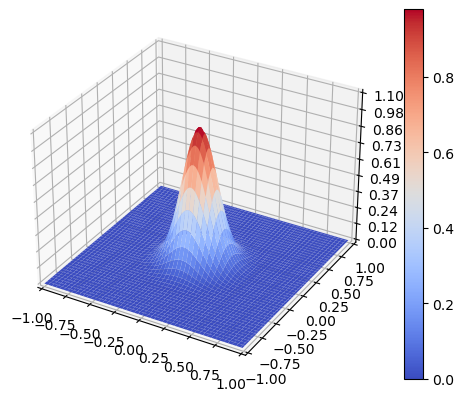

In [110]:
a = -1
b = 1
dx = .01
dy = .01
n_points = 100

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x = np.linspace(a,b-dx,n_points)
y = np.linspace(a,b-dy,n_points)

X, Y = np.meshgrid(x,y)
Z = np.exp(-(X**2 + Y**2)/.05)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 1.1)
ax.zaxis.set_major_locator(LinearLocator(10))

ax.zaxis.set_major_formatter('{x:.02f}')
surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm)
fig.colorbar(surf)

In [146]:
def all_in_one_2D_animate(n_points):

    ############################################################################################################
    # Input Data
    ############################################################################################################

    # Spatial Domain
    a = -1
    b = 1
    n_ghost = 3
    delta_x = (b-a)/(n_points)
    delta_y = delta_x
    x = np.linspace(a,b-delta_x,n_points)
    y = np.linspace(a,b-delta_y,n_points)
    X,Y = np.meshgrid(x,y)
    
    # Time Domain
    t0 = 0    
    t1 = 1
    delta_t = 0.001
    
    # ... Wave Speed
    wave_speed = 1.0

    # Advection
    flux = lambda w: wave_speed*w
    dflux = lambda w: wave_speed

    # Burgers'
    # flux = lambda w: w**2 / 2
    # dflux = lambda w: w

    ############################################################################################################
    # Generate Cell Averages
    ############################################################################################################

    cell_val = np.zeros(n_points)
    exact_soln = np.zeros(n_points)


    # for i in range(n_points):
    #     cell_val[i] = riemann(grid[i])
    #     exact_soln[i] = riemann(grid[i] - wave_speed*t1 )

    # cell_val = np.sin( np.pi * grid)
    # cell_val = np.exp(-(grid/.1)**2)
    cell_val = np.exp(-(X**2 + Y**2)/.1)
    # cell_val = np.ones(n_points)
    # cell_val[0:int(n_points/2)] = 0
    # exact_soln = np.sin(np.pi * (grid - wave_speed*t1 ) )

    # initial_soln = np.copy(cell_val)
    # v_val = add_ghost_cells(np.copy(cell_val),n_points,n_ghost)

    v_val = np.zeros([cell_val.shape[0] + 2*n_ghost, cell_val.shape[0] + 2*n_ghost])
    v_val[n_ghost:-n_ghost,n_ghost:-n_ghost] = cell_val

    v_val_1 = np.copy(v_val)
    v_val_2 = np.copy(v_val)
    v_val_new = np.copy(v_val)

    value_history = np.zeros([n_points,n_points,int(t1/delta_t)])

    ############################################################################################################
    # Time March
    ############################################################################################################

    t = t0
    n = 0
    while t < (t1):

        for j in range(n_ghost,n_points+n_ghost):
            # Forward Euler
            v_val_line_x = boundary_conditions(v_val[:,j],n_ghost,"periodic")
            v_val_new = np.zeros(len(v_val_line_x))
            for i in range(n_ghost,n_points+n_ghost):
                v_val_line_y = boundary_conditions(v_val[i,:],n_ghost,"periodic")
                f_l = weno_flux_splitting(np.array([v_val_line_x[i-3],v_val_line_x[i-2],v_val_line_x[i-1],v_val_line_x[i],v_val_line_x[i+1],v_val_line_x[i+2]]),flux,dflux)
                f_r = weno_flux_splitting(np.array([v_val_line_x[i-2],v_val_line_x[i-1],v_val_line_x[i],v_val_line_x[i+1],v_val_line_x[i+2],v_val_line_x[i+3]]),flux,dflux)
                f_d = weno_flux_splitting(np.array([v_val_line_y[j-3],v_val_line_y[j-2],v_val_line_y[j-1],v_val_line_y[j],v_val_line_y[j+1],v_val_line_y[j+2]]),flux,dflux)
                f_u = weno_flux_splitting(np.array([v_val_line_y[j-2],v_val_line_y[j-1],v_val_line_y[j],v_val_line_y[j+1],v_val_line_y[j+2],v_val_line_y[j+3]]),flux,dflux)
                v_val_new[i] = v_val[i,j] - ((delta_t)/(delta_x))*(f_r - f_l) - (delta_t/delta_y)*(f_u - f_d)
            v_val[:,j] = np.copy(v_val_new)
        
        value_history[:,:,n] = np.copy(v_val[n_ghost:-n_ghost,n_ghost:-n_ghost])
        t += delta_t
        n += 1

        # plt.plot(grid,initial_soln,color = 'crimson', linestyle='-',linewidth=2.5,label='Initial Condition')
        # plt.plot(grid,v_val[n_ghost:-n_ghost],color = 'gold', linestyle=':',linewidth=2.5,label='WENO Solution')

    # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')

    def animate(i):

        ax.clear()

        # x = np.linspace(a,b-dx,n_points)
        # y = np.linspace(a,b-dy,n_points)

        # X, Y = np.meshgrid(x,y)
        # Z = np.exp(-(X**2 + Y**2)/.05)

        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(0, 1.1)
        ax.zaxis.set_major_locator(LinearLocator(10))

        ax.zaxis.set_major_formatter('{x:.02f}')
        ax.plot_surface(X, Y, value_history[:,:,i], cmap = cm.coolwarm)
        # fig.colorbar(surf)

        return fig,

    ani = FuncAnimation(fig, animate, interval=40, repeat=True, frames=int(t1 / delta_t))    
    # writer = animation.FFMpegWriter(fps=60, metadata=dict(artist='Me'), bitrate=1800)
    # ani.save("burgers_2D_surf.gif",writer=writer)
    ani.save("advection_2D_surf.gif", dpi=150, writer=PillowWriter(fps=30))

    return


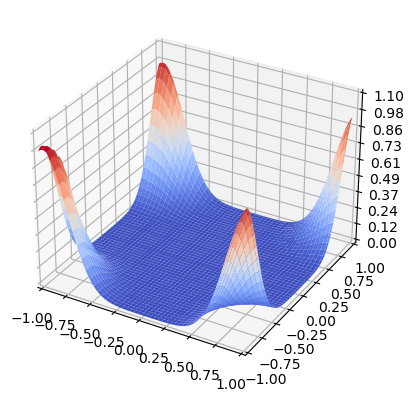

In [147]:
all_in_one_2D_animate(100)

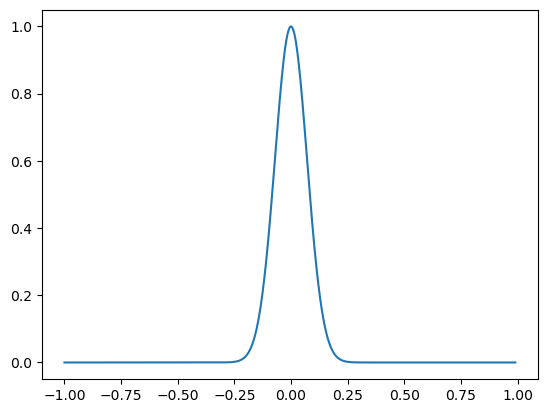

In [91]:
a = -1
b = 1
delta_x = .01
n_points = 1001
grid = np.linspace(a,b-delta_x,n_points)
y = np.exp(-(grid/.1)**2)
plt.plot(grid,y)